## DFO Si Plots

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean

mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=12)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=12)
mpl.rc('font', size=12)
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble = ','.join(r'''
 \usepackage{txfonts}
 \usepackage{lmodern}
 '''.split()))
mpl.rc('font', family='sans-serif', weight='normal', style='normal')
%matplotlib inline

In [2]:
df=et.loadDFO()
df.head()

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,Chlorophyll_Extracted,Chlorophyll_Extracted_units,N,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC
0,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,12.0,NaN,None,5.28,mg/m^3,6.6,13.6,umol/L,NaN,NaN,12.0,1982-07-16 01:21:00
1,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,21.5,NaN,None,0.61,mg/m^3,21.2,45.0,umol/L,NaN,NaN,21.5,1982-07-16 01:21:00
2,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,30.5,NaN,None,NaN,mg/m^3,23.5,47.4,umol/L,NaN,NaN,30.5,1982-07-16 01:21:00
3,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,52.3,NaN,None,NaN,mg/m^3,28.0,50.2,umol/L,NaN,NaN,52.3,1982-07-16 01:21:00
4,1982.0,7.0,16.0,1.35,49.25,-123.943,NaN,75.4,NaN,None,NaN,mg/m^3,26.5,49.1,umol/L,NaN,NaN,75.4,1982-07-16 01:21:00


In [3]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    navlon=mesh.variables['nav_lon'][:,:]
    navlat=mesh.variables['nav_lat'][:,:]
    tmask=mesh.variables['tmask'][:,:,:,:]
    gdept=mesh.variables['gdept_1d'][0,:]
    e3t0=mesh.variables['e3t_0'][0,:,:,:]
bathy=np.sum(e3t0,0)
with nc.Dataset('/results/SalishSea/hindcast.201812/01jan16/SalishSea_1h_20160101_20160101_ptrc_T.nc') as ftemp:
        bounds=np.copy(ftemp.variables['deptht_bounds'][:,:])

In [4]:
#d1=et._gridHoriz(df.loc[df.Z>150].copy(deep=True),tmask,navlon,navlat,wrapSearch=False,resetIndex=True);
d1=et._gridHoriz(df.copy(deep=True),tmask,navlon,navlat,wrapSearch=False,resetIndex=True);
d1['k']=np.nan
for ind, row in d1.iterrows():
    ik=et._getZInd_bin(row['Z'],None,boundsFlag=True)
    if (not np.isnan(ik)) and (tmask[0,ik,row['j'],row['i']]==1):
        d1.loc[ind,['k']]=ik

(Lat,Lon)= 47.05 -122.31666666666666  not matched to domain
(Lat,Lon)= 47.1 -122.7  not matched to domain
(Lat,Lon)= 47.1 -122.68333333333334  not matched to domain
(Lat,Lon)= 47.166666666666664 -122.51666666666667  not matched to domain
(Lat,Lon)= 49.29933333333334 -122.983  not matched to domain
(Lat,Lon)= 49.30222166666667 -122.94861166666666  not matched to domain
(Lat,Lon)= 49.3025 -122.939445  not matched to domain
(Lat,Lon)= 49.3025 -122.93277833333333  not matched to domain
(Lat,Lon)= 49.304833333333335 -122.94116666666666  not matched to domain
(Lat,Lon)= 49.306945 -122.941945  not matched to domain
(Lat,Lon)= 49.30722166666666 -122.93527833333333  not matched to domain
(Lat,Lon)= 49.312778333333334 -122.94111166666667  not matched to domain
(Lat,Lon)= 49.312778333333334 -122.9325  not matched to domain
(Lat,Lon)= 50.47666666666667 -126.17833333333333  not matched to domain
(Lat,Lon)= 50.4882 -126.3484  not matched to domain
(Lat,Lon)= 50.49666666666667 -126.31166666666667  no

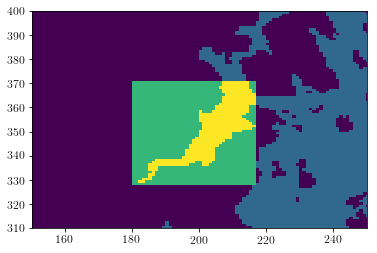

In [5]:
# drop Saanich Inlet
tmask2=np.copy(tmask[0,0,:,:])
tmask2[328:371,180:217]=tmask[0,0,328:371,180:217]+2
plt.pcolormesh(tmask2)
plt.xlim(150,250)
plt.ylim(310,400)
d1.drop(d1.loc[(d1.i>=180)&(d1.i<217)&(d1.j>=328)&(d1.j<371)].index.values,inplace=True)
# also drop east side Vancouver Island points:
d1.drop(d1.loc[(d1.i<10)&(d1.j>=460)&(d1.j<480)].index.values,inplace=True)

In [6]:
d1['YD']=[(dt.datetime(int(yy),int(mm),int(dd))-dt.datetime(int(yy),1,1)).total_seconds()/(24*3600) for yy,mm,dd in zip(d1['Year'].values,d1['Month'].values,d1['Day'].values)]

In [7]:
np.unique(d1.loc[(d1.N==0)&(d1.Z>20),['Year']])

array([2006.])

In [8]:
d1.loc[(d1.N==0)&(d1.Z>20)]

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,...,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC,j,i,k,YD
11627,2006.0,6.0,16.0,6.132222,49.443333,-124.337167,125.2,NaN,NaN,None,...,17.4,umol/L,30.487816,8.774221,124.095477,2006-06-16 06:07:56,567,183,27.0,166.0


In [9]:
d1.loc[(d1.Si==0)&(d1.Z>20)]

,Year,Month,Day,Hour,Lat,Lon,Pressure,Depth,Ammonium,Ammonium_units,...,Si,Silicate_units,AbsSal,ConsT,Z,dtUTC,j,i,k,YD
21422,1932.0,4.0,1.0,22.0,48.866667,-122.866667,NaN,30.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,30.0,1932-04-01 22:00:00,351,327,21.0,91.0
21423,1932.0,4.0,1.0,22.0,48.866667,-122.866667,NaN,50.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,50.0,1932-04-01 22:00:00,351,327,23.0,91.0
21424,1932.0,4.0,1.0,22.0,48.866667,-122.866667,NaN,100.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,100.0,1932-04-01 22:00:00,351,327,NaN,91.0
21425,1932.0,4.0,1.0,22.0,48.866667,-122.866667,NaN,180.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,180.0,1932-04-01 22:00:00,351,327,NaN,91.0
21433,1932.0,4.0,1.0,18.0,48.866667,-122.866667,NaN,30.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,30.0,1932-04-01 18:00:00,351,327,21.0,91.0
21434,1932.0,4.0,1.0,18.0,48.866667,-122.866667,NaN,50.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,50.0,1932-04-01 18:00:00,351,327,23.0,91.0
21435,1932.0,4.0,1.0,18.0,48.866667,-122.866667,NaN,100.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,100.0,1932-04-01 18:00:00,351,327,NaN,91.0
21436,1932.0,4.0,1.0,18.0,48.866667,-122.866667,NaN,180.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,180.0,1932-04-01 18:00:00,351,327,NaN,91.0
21444,1932.0,4.0,2.0,5.0,48.866667,-122.866667,NaN,30.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,30.0,1932-04-02 05:00:00,351,327,21.0,92.0
21445,1932.0,4.0,2.0,5.0,48.866667,-122.866667,NaN,50.0,NaN,None,...,0.0,mmol/m**3,NaN,NaN,50.0,1932-04-02 05:00:00,351,327,23.0,92.0


In [10]:
def binmean(ddf,latEdges,lonEdges):
    latbins=np.digitize(ddf.Lat,latEdges)
    lonbins=np.digitize(ddf.Lon,lonEdges)
    midLats=.5*(latEdges[:-1]+latEdges[1:])
    midLons=.5*(lonEdges[:-1]+lonEdges[1:])
    xxlon,xxlat=np.meshgrid(midLons,midLats)
    sums=np.zeros(np.shape(xxlon))
    counts=np.zeros(np.shape(xxlon))
    means=np.nan*np.ones(np.shape(xxlon))
    for jj in range(0,len(midLats)):
        for ii in range(0,len(midLons)):
            if len(ddf.loc[(latbins==jj+1)&(lonbins==ii+1),['Si']])>=1:
                means[jj,ii]=np.sum(ddf.loc[(latbins==jj+1)&(lonbins==ii+1),['Si']])/len(ddf.loc[(latbins==jj+1)&(lonbins==ii+1),['Si']])
    return xxlon, xxlat, means

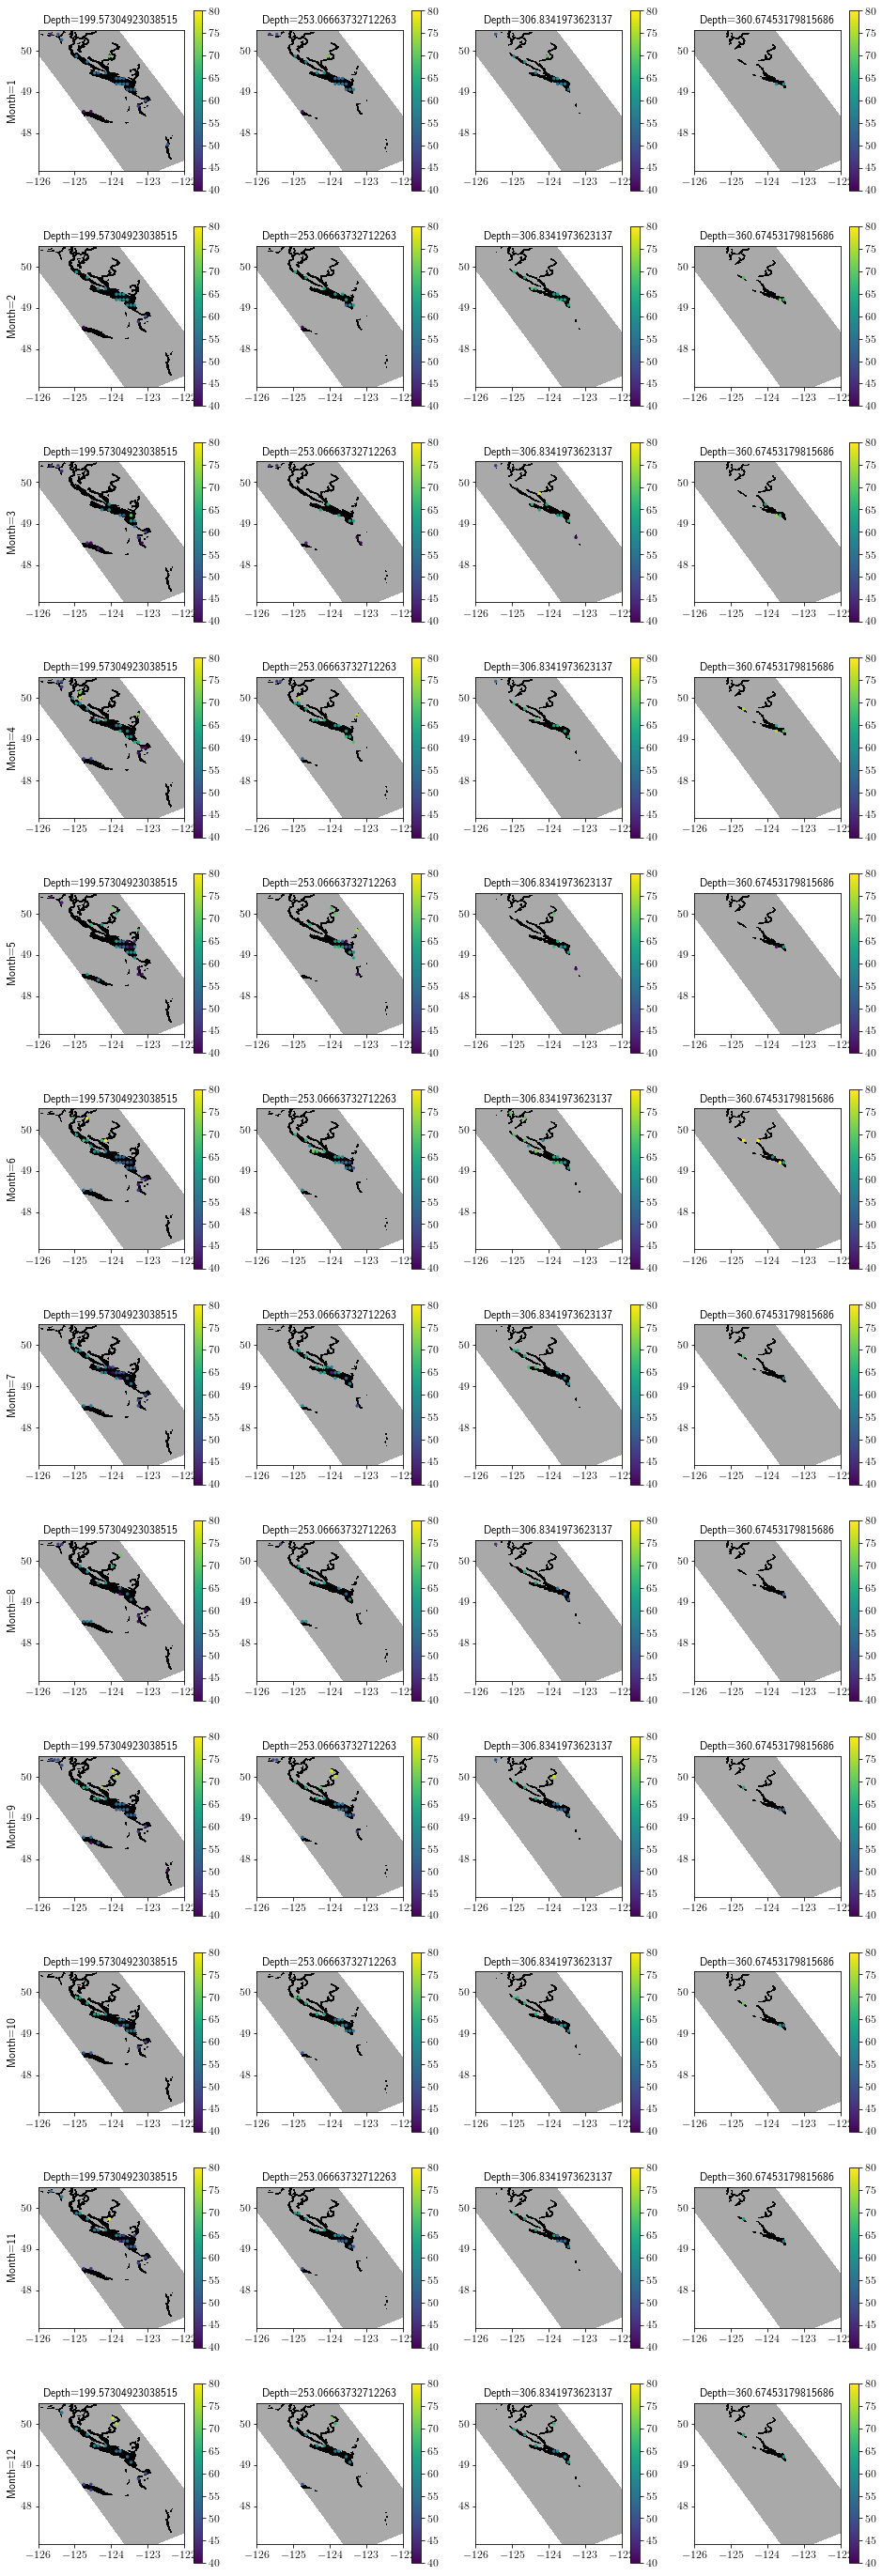

In [11]:
fig,ax=plt.subplots(12,4,figsize=(16,50))
#kk=30 #36,34,32,30
simin=40
simax=80
for mon in range(1,13):
    iax=ax[mon-1,0]
    kk=30
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','k','k'))
    viz_tools.set_aspect(iax,coords='map')
    idf=d1.loc[(d1.k==kk)&(d1.Si>=0)&(d1.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_ylabel('Month='+str(mon))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)
    
    iax=ax[mon-1,1]
    kk=32
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','k','k'))
    viz_tools.set_aspect(iax,coords='map')
    idf=d1.loc[(d1.k==kk)&(d1.Si>=0)&(d1.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)
    
    iax=ax[mon-1,2]
    kk=34
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','k','k'))
    viz_tools.set_aspect(iax,coords='map')
    idf=d1.loc[(d1.k==kk)&(d1.Si>=0)&(d1.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)
    
    iax=ax[mon-1,3]
    kk=36
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','k','k'))
    viz_tools.set_aspect(iax,coords='map')
    idf=d1.loc[(d1.k==kk)&(d1.Si>=0)&(d1.Month==mon)]
    lo,la,mm=binmean(idf,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    iax.set_title('Depth='+str(gdept[kk]))
    iax.set_xlim(-126,-122)
    iax.set_ylim(47.1,50.5)

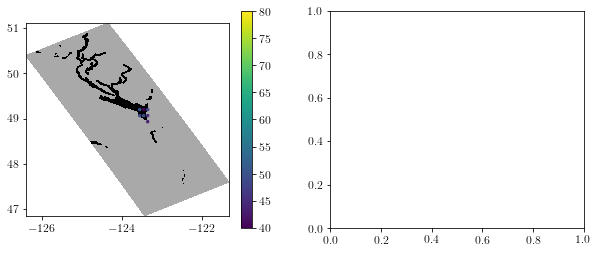

In [12]:
fig,ax=plt.subplots(1,2,figsize=(10,4))
#kk=30 #36,34,32,30
simin=40
simax=80
for mon in range(1,2):

    iax=ax[0];#ax[mon-1,1]
    kk=32
    iax.contourf(navlon,navlat,tmask[0,kk,:,:],levels=(0,.5,1.5),lw=.5,colors=('darkgray','k','k'))
    viz_tools.set_aspect(iax,coords='map')
    d1bath=np.array([bathy[j,i] for i,j in zip(d1['i'],d1['j'])])
    df0=d1.loc[(d1.Lon<-123.3)&(d1.Lon>-123.6)&(d1.Lat<49.2)&(d1.Lat>48.85)&(d1.Si>=0)&(d1bath>400)]
    lo,la,mm=binmean(df0,latEdges=np.linspace(47,51,31),lonEdges=np.linspace(-126,-122,41))
    #iax.pcolormesh(lo,la,np.ma.masked_where(np.isnan(mm),mm))
    mesh=iax.scatter(lo,la,c=mm,s=6,vmin=simin,vmax=simax)
    plt.colorbar(mesh,ax=iax)
    #iax.set_title('Depth='+str(gdept[kk]))
    
    

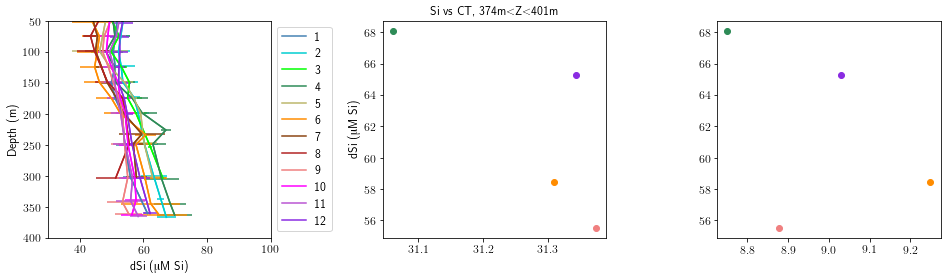

In [13]:
fig,ax=plt.subplots(1,3,figsize=(16,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=37
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs CT, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

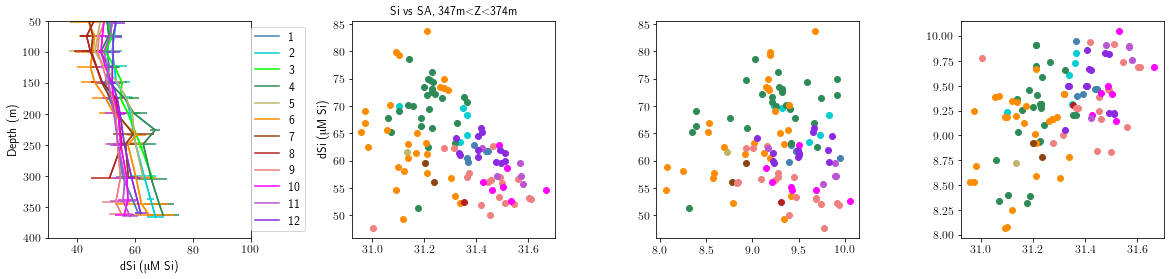

In [14]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=36
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

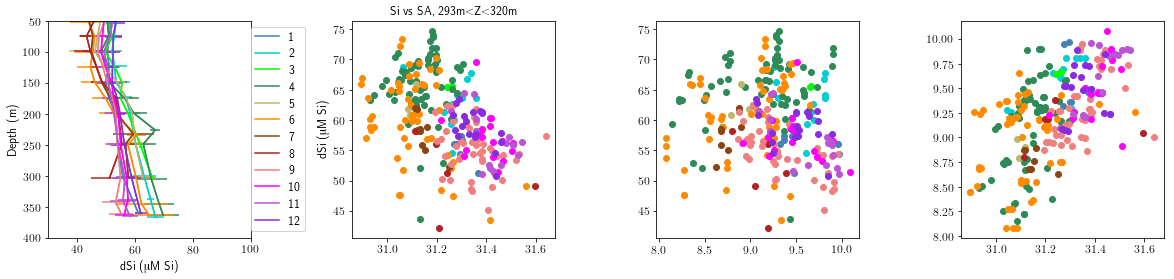

In [15]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=34
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

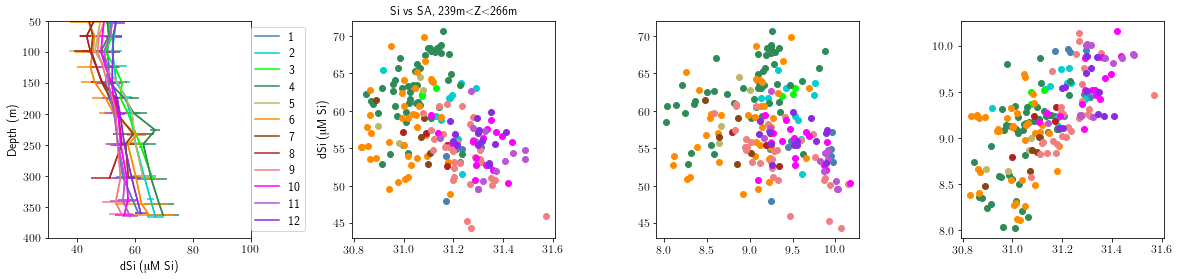

In [16]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=32
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

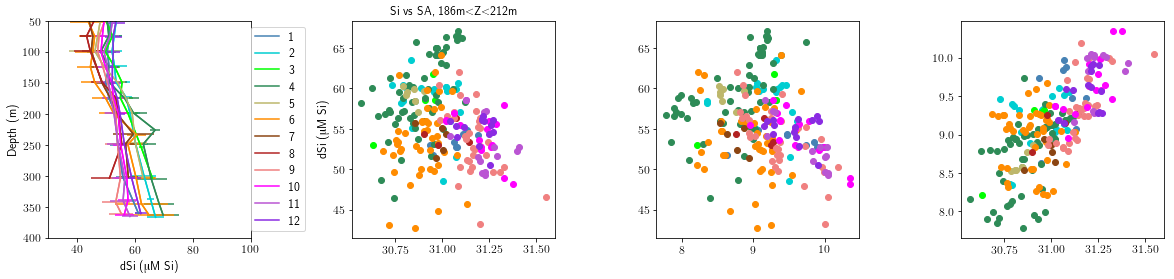

In [17]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=30
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

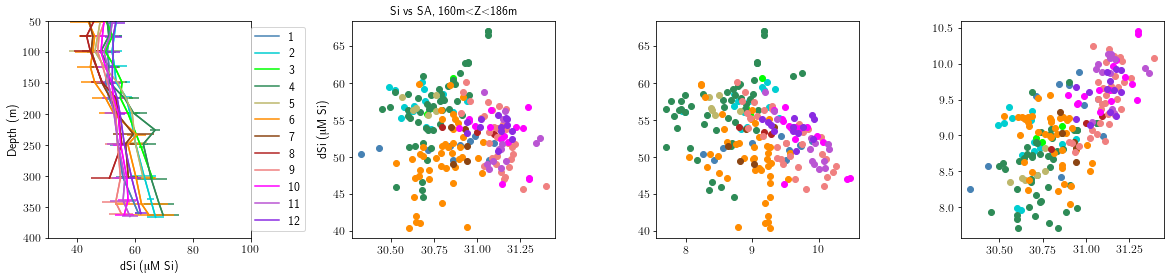

In [18]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=29
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

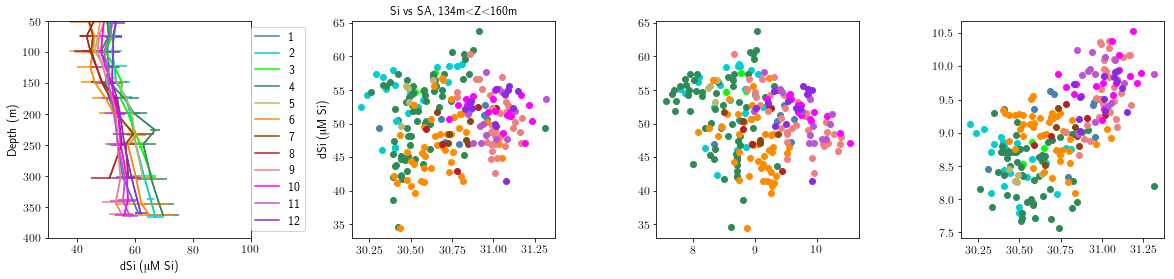

In [19]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=28
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

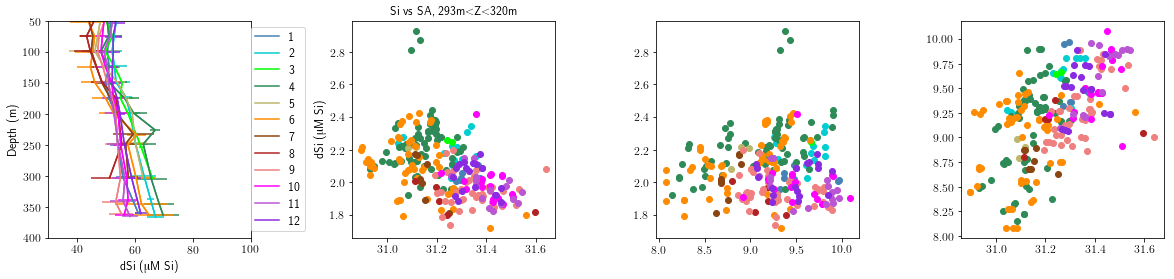

In [20]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
for valm, groupedm in df0.groupby(['Month']):
    ik=34
    ax[1].plot(groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['AbsSal']],
               groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['Si']].values/groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['N']].values,
               'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['ConsT']],
               groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['Si']].values/groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['N']].values,
               'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['AbsSal']],
               groupedm.loc[(groupedm.k==ik)&(groupedm.N>=0),['ConsT']].values,
               'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[1],ps[2],ps[3],ps[4],ps[5],ps[6],ps[7],ps[8],ps[9],ps[10],ps[11],ps[12]],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

In [21]:
df0.loc[(df0.k==34)].groupby(['Year'])['Si'].count()

Year
1978.0     1
1996.0     7
1997.0     4
1998.0     6
1999.0     2
2000.0     9
2001.0    11
2002.0    16
2003.0    14
2004.0    11
2005.0    13
2006.0    12
2007.0    11
2008.0    12
2009.0    12
2010.0    20
2011.0    15
2012.0    12
2013.0     9
2014.0    14
2015.0     9
2016.0    12
2017.0    12
2018.0     9
Name: Si, dtype: int64

In [22]:
df0.loc[(df0.k==35)].groupby(['Year'])['Si'].count()

Year
1996.0    3
1997.0    3
1998.0    3
1999.0    1
2000.0    3
2001.0    3
2002.0    3
2003.0    3
2004.0    2
2005.0    2
2006.0    3
2008.0    3
2010.0    4
2011.0    3
2013.0    2
2014.0    3
2015.0    1
2016.0    2
2017.0    4
2018.0    2
Name: Si, dtype: int64

In [23]:
df0.loc[(df0.k==36)].groupby(['Year'])['Si'].count()

Year
1996.0     3
1997.0     2
1998.0     3
1999.0     1
2000.0     3
2001.0     5
2002.0     7
2003.0     9
2004.0     6
2005.0     6
2006.0     5
2007.0     5
2008.0     5
2009.0     8
2010.0    11
2011.0     3
2012.0     5
2013.0     4
2014.0     5
2015.0     3
2016.0     6
2017.0     4
2018.0     2
Name: Si, dtype: int64

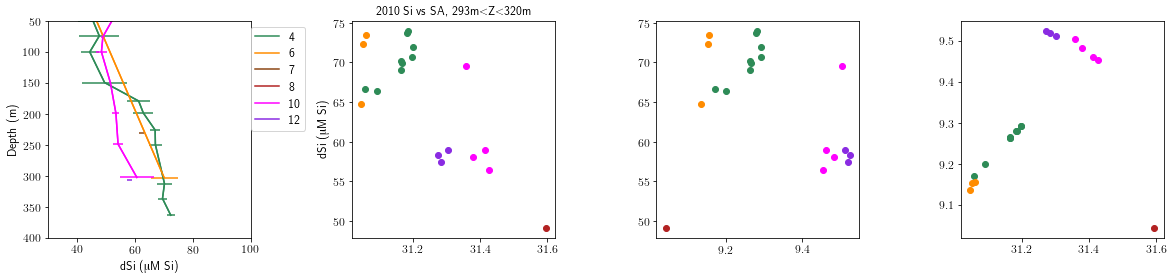

In [24]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
df1=df0.loc[df0.Year==2010]
for valm, groupedm in df1.groupby(['Month']):
    ik=34
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[ii] for ii in range(1,13) if ii in ps.keys()],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('2010 Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

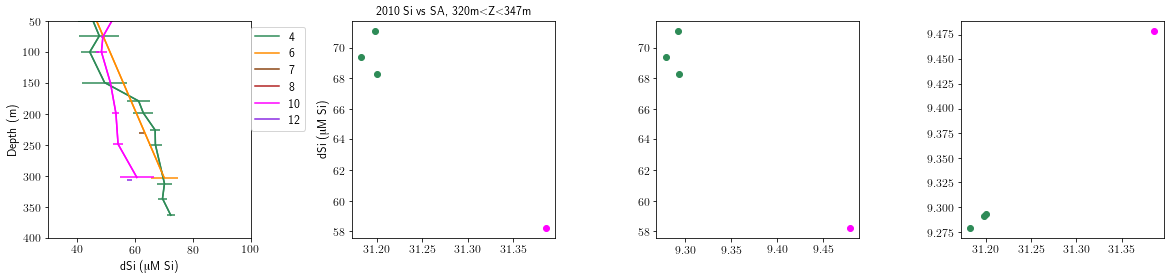

In [25]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
df1=df0.loc[df0.Year==2010]
for valm, groupedm in df1.groupby(['Month']):
    ik=35
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[ii] for ii in range(1,13) if ii in ps.keys()],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title('2010 Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

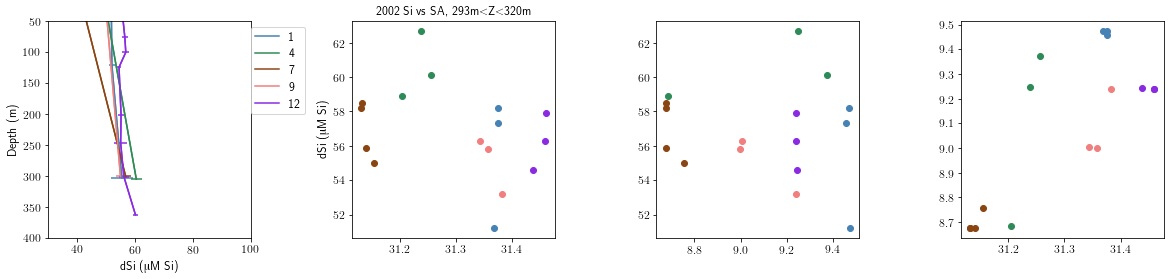

In [26]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
df1=df0.loc[df0.Year==2002]
for valm, groupedm in df1.groupby(['Month']):
    ik=34
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[ii] for ii in range(1,13) if ii in ps.keys()],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title(' 2002 Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

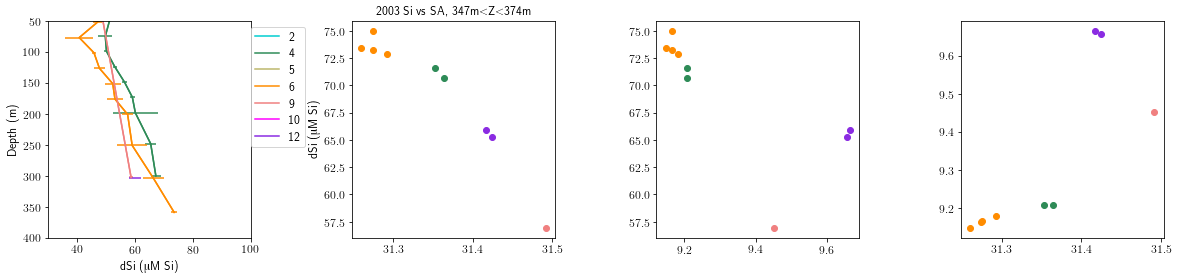

In [27]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
df1=df0.loc[df0.Year==2003]
for valm, groupedm in df1.groupby(['Month']):
    ik=36
    ax[1].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[2].plot(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],'o',color=col[int(valm)],alpha=1)
    ax[3].plot(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],'o',color=col[int(valm)],alpha=1)
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[ii] for ii in range(1,13) if ii in ps.keys()],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title(' 2003 Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')

In [28]:
df1.keys()

Index(['Year', 'Month', 'Day', 'Hour', 'Lat', 'Lon', 'Pressure', 'Depth',
       'Ammonium', 'Ammonium_units', 'Chlorophyll_Extracted',
       'Chlorophyll_Extracted_units', 'N', 'Si', 'Silicate_units', 'AbsSal',
       'ConsT', 'Z', 'dtUTC', 'j', 'i', 'k', 'YD'],
      dtype='object')

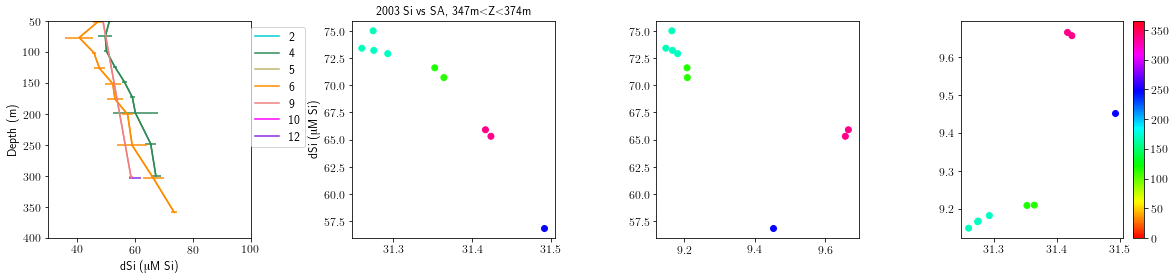

In [29]:
fig,ax=plt.subplots(1,4,figsize=(20,4))
fig.subplots_adjust(wspace=.5)
col=('midnightblue','steelblue','darkturquoise','lime',
     'seagreen','darkkhaki','darkorange','saddlebrown','firebrick',
     'lightcoral','fuchsia','mediumorchid','blueviolet')
ps=dict()
df1=df0.loc[df0.Year==2003]
for valm, groupedm in df1.groupby(['Month']):
    ik=36
    cmin=0
    cmax=365
    if np.sum(groupedm.k==ik)>0:
        ax[1].scatter(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['Si']],c=groupedm.loc[groupedm.k==ik,['YD']],
                      vmin=cmin,vmax=cmax,cmap=plt.get_cmap('hsv'))
        ax[2].scatter(groupedm.loc[groupedm.k==ik,['ConsT']],groupedm.loc[groupedm.k==ik,['Si']],c=groupedm.loc[groupedm.k==ik,['YD']],
                      vmin=cmin,vmax=cmax,cmap=plt.get_cmap('hsv'))
        m=ax[3].scatter(groupedm.loc[groupedm.k==ik,['AbsSal']],groupedm.loc[groupedm.k==ik,['ConsT']],c=groupedm.loc[groupedm.k==ik,['YD']],
                        vmin=cmin,vmax=cmax,cmap=plt.get_cmap('hsv'))
    means=groupedm.groupby(['k']).agg({'Si':np.mean,'Z':np.mean})
    stds=groupedm.groupby(['k']).agg({'Si':np.std})
    ns=groupedm.groupby(['k'])['Si'].count()
    ps[int(valm)],=ax[0].plot(means['Si'][ns>2],means['Z'][ns>2],'-',color=col[int(valm)],
               label=str(int(valm)))
    ax[0].errorbar(means['Si'][ns>2],means['Z'][ns>2],xerr=stds['Si'][ns>2],color=col[int(valm)])
ax[0].legend(handles=[ps[ii] for ii in range(1,13) if ii in ps.keys()],
         bbox_to_anchor=(1.3, 1.0))
ax[0].set_ylim(400,50)
ax[0].set_xlim(30,100)
ax[0].set_ylabel('Depth (m)')
ax[0].set_xlabel('dSi ($\muup$M Si)')
ax[1].set_ylabel('dSi ($\muup$M Si)')
ax[1].set_title(' 2003 Si vs SA, '+str(int(bounds[ik,0]))+'m$<$Z$<$'+str(int(bounds[ik,1]))+'m')
fig.colorbar(m,ax=ax[3])

In [30]:
df1.loc[df1.k==ik,['Year','Month','Day','Lat','Lon','Pressure','Si','AbsSal','ConsT']]

,Year,Month,Day,Lat,Lon,Pressure,Si,AbsSal,ConsT
40566,2003.0,4.0,26.0,49.163000,-123.550167,371.7,70.7,31.364321,9.209034
40599,2003.0,4.0,27.0,49.162833,-123.549500,375.0,71.6,31.352728,9.208075
40699,2003.0,6.0,19.0,49.164000,-123.548167,352.7,73.4,31.260225,9.148055
40700,2003.0,6.0,19.0,49.164000,-123.548167,369.9,75.0,31.274537,9.164992
40732,2003.0,6.0,20.0,49.163333,-123.549500,352.3,73.2,31.275391,9.166978
40733,2003.0,6.0,20.0,49.163333,-123.549500,372.2,72.9,31.293075,9.181456
40807,2003.0,9.0,5.0,49.162333,-123.547500,372.3,56.9,31.491569,9.452973
40914,2003.0,12.0,4.0,49.163667,-123.547833,353.2,65.9,31.417017,9.665293
40915,2003.0,12.0,4.0,49.163667,-123.547833,373.8,65.3,31.423961,9.656753


(49.16, 49.17)

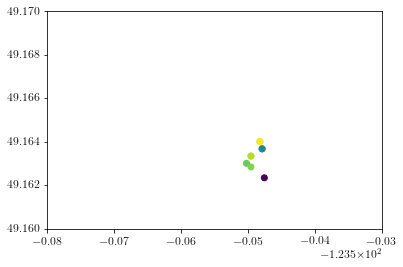

In [31]:
plt.scatter(df1.loc[df1.k==ik,['Lon']],df1.loc[df1.k==ik,['Lat']],c=df1.loc[df1.k==ik,['Si']])
plt.xlim(-123.58,-123.53)
plt.ylim(49.16,49.17)

In [32]:
plt.scatter(xx,xx,c=xx)

NameError: name 'xx' is not defined